# Data Exploration

In [1]:
from PreProcessing import Cleaned_X_Y, clean_doc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
filename = "Roman Urdu DataSet.csv"

In [3]:
X, y = Cleaned_X_Y(filename)

In [4]:
df = pd.read_csv(filename, encoding='utf8', header=None)
df.columns = ['text','target','junk']
df.drop('junk',axis=1, inplace=True)
df.dropna(inplace=True)
data = df[df['target'] != 'Neative']

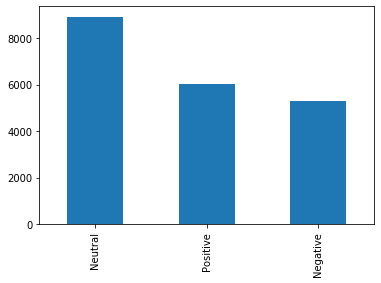

In [5]:
data['target'].value_counts().plot.bar()

In [6]:
data['target'].value_counts()

Neutral     8928
Positive    6013
Negative    5286
Name: target, dtype: int64

In [7]:
# Buid a feature to get the character length in each reviews
data['char_len'] = data['text'].apply(lambda x: len(x) - x.count(" "))

In [8]:
# Buid a feature to get the word count in each reviews
data['word_count'] = data['text'].apply(lambda x: len(x.split(" ")))

In [9]:
data.head(5)

,text,target,char_len,word_count
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,73,25
1,sahi bt h,Positive,7,3
2,"Kya bt hai,",Positive,9,3
3,Wah je wah,Positive,8,3
4,Are wha kaya bat hai,Positive,16,5


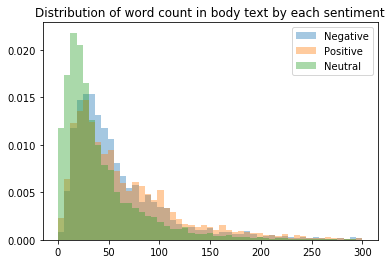

In [10]:
# Distribution of Character Length across the entire review corpus
bins = np.linspace(0, 300, 50)
plt.hist(data[data['target']=='Negative']['char_len'], bins, density = True, alpha =0.4, label = 'Negative')
plt.hist(data[data['target']=='Positive']['char_len'], bins, density = True, alpha =0.4, label = 'Positive')
plt.hist(data[data['target']=='Neutral']['char_len'], bins, density = True, alpha =0.4, label = 'Neutral')
plt.legend(loc='upper right')
plt.title('Distribution of word count in body text by each sentiment')
plt.show()

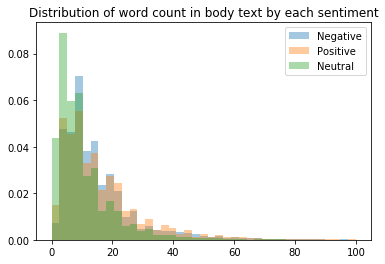

In [11]:
# Distribution of Character Length across the entire review corpus
bins = np.linspace(0, 100, 40)
plt.hist(data[data['target']=='Negative']['word_count'], bins, density = True, alpha =0.4, label = 'Negative')
plt.hist(data[data['target']=='Positive']['word_count'], bins, density = True, alpha =0.4, label = 'Positive')
plt.hist(data[data['target']=='Neutral']['word_count'], bins, density = True, alpha =0.4, label = 'Neutral')
plt.legend(loc='upper right')
plt.title('Distribution of word count in body text by each sentiment')
plt.show()

In [12]:
# Create dataset files for analysis based on the size / length of the reviews.
data[data['char_len'] > 50].to_csv('reviews_greater_50.csv',header = True, index = False)
data[data['char_len'] < 50].to_csv('reviews_lesser_50.csv',header = True, index = False)

In [13]:
reviews_greater_50 = data[data['char_len'] > 50]
reviews_lesser_50 = data[data['char_len'] <= 50]

In [14]:
corp = []
for sentence in data['text'].values:
    corp = corp + sentence.split()
print("Total No of Words : ", len(corp))
print("Size of the Vocabuary : ", len(set(corp)))

Total No of Words :  268722
Size of the Vocabuary :  45124


## Building Sentiment Classification on Traditional Machine Learning Model

In [15]:
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [16]:
data['target'].value_counts()

Neutral     8928
Positive    6013
Negative    5286
Name: target, dtype: int64

In [17]:
#data_2 = data[data['target'].isin(['Positive', 'Negative'])]
#data_2['target'].value_counts()

In [18]:
# Lambda function to clean the text reviews.
clean_text = data['text'].apply(lambda x: clean_doc(x))

In [19]:
y = data['target'].values
enc = LabelEncoder()
y = enc.fit_transform(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data[['text', 'char_len', 'word_count']],
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)

In [21]:
vectorizer = TfidfVectorizer(analyzer=clean_doc,ngram_range=(1, 2)) 
vectorizer = vectorizer.fit(X_train['text'])
x_train_v = vectorizer.transform(X_train['text'])
x_test_v = vectorizer.transform(X_test['text'])

In [22]:
X_train_c = pd.concat([X_train[['char_len', 'word_count']].reset_index(drop=True),
                          pd.DataFrame(x_train_v.toarray())], axis=1)
X_test_c = pd.concat([X_test[['char_len', 'word_count']].reset_index(drop=True),
                         pd.DataFrame(x_test_v.toarray())], axis=1)

In [23]:
# Shape of the Training data X and Y
print("Shape of the Training data X : {}, Y : {}".format(X_train_c.shape, y_train.shape))

Shape of the Training data X : (16181, 27887), Y : (16181,)


# Random Forest

Precision: 0.64 | Recall: 0.64 | Accuracy: 0.64


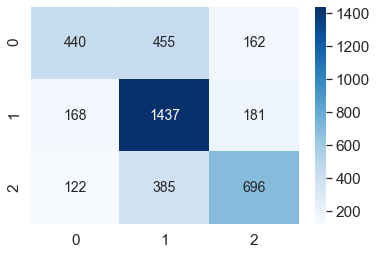

In [24]:
# n_jobs = -1 for building parallel 150 decision trees. 
# Max_depth = None means it will build decision tree until minminzation of loss
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1,class_weight="balanced",random_state=42)
rf_model = rf.fit(X_train_c, y_train)
y_pred = rf_model.predict(X_test_c)

precision = precision_score(y_test, y_pred, pos_label='positive', average='weighted')
recall = recall_score(y_test, y_pred, pos_label='positive', average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print('Precision: {:.2f} | Recall: {:.2f} | Accuracy: {:.2f}'.format(precision,recall,accuracy))

sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="Blues", annot=True,annot_kws={"size": 14}, fmt='g')# font size

# Logistic Regression

Precision: 0.65 | Recall: 0.65 | Accuracy: 0.65


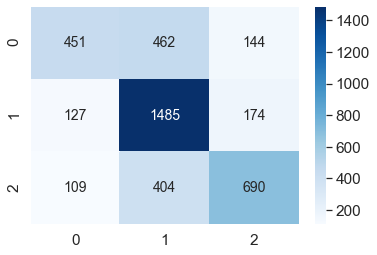

In [26]:
classifier = LogisticRegression(random_state=0,solver='liblinear',multi_class='auto')
classifier.fit(X_train_c, y_train)
y_pred = classifier.predict(X_test_c)

precision = precision_score(y_test, y_pred, pos_label='positive', average='weighted')
recall = recall_score(y_test, y_pred, pos_label='positive', average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print('Precision: {:.2f} | Recall: {:.2f} | Accuracy: {:.2f}'.format(precision,recall,accuracy))

sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="Blues", annot=True,annot_kws={"size": 14}, fmt='g')# font size